In [1]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import TensorDataset, ConcatDataset, Subset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from itertools import chain

from tqdm import tqdm, trange
from matplotlib import pyplot as plt
from matplotlib import animation
from matplotlib.colors import Normalize
from IPython.display import HTML

In [2]:
def to_tensor(ar):
    return torch.tensor(ar, dtype=torch.float)

data = to_tensor(np.load('dataTM.npy'))
mask = to_tensor(np.expand_dims(plt.imread('mask.png')[:-1,:,0]<0.5,(0,1))).cuda()
avg = to_tensor(np.expand_dims(np.load('avg.npy')[:-1],(0,1))).cuda()

print(data.shape, mask.shape, avg.shape)

torch.Size([791, 9, 824, 200]) torch.Size([1, 1, 824, 200]) torch.Size([1, 1, 824, 200])


In [3]:
BPTT_WINDOW = 6
PRED_WINDOW = 3
BATCH_SIZE = 4

In [4]:
def get_subseter(dataset, bptt_len=6):
    indices = [np.arange(i, i + bptt_len) for i in range(len(dataset)-bptt_len)]
    return Subset(dataset, indices)

def get_datasets(bptt_len=6, pred_len=3):
    global data
    p = pred_len
    train1 = get_subseter(TensorDataset(data[:61-p], data[p:61, 0]), bptt_len)
    train2 = get_subseter(TensorDataset(data[334: 426-p], data[p+334: 426, 0]), bptt_len)
    val = get_subseter(TensorDataset(data[699: 750-p], data[p+699: 750, 0]), bptt_len)
    test = get_subseter(TensorDataset(data[699:-p], data[p+699:, 0]), bptt_len)
    return train1, train2, val, test

# loaders, shape is x:(batch, time, channel, height, width) y:(batch, time, height, width)
train1, train2, val, test = [DataLoader(dataset, BATCH_SIZE, sampler=RandomSampler(dataset)) \
                    for dataset in get_datasets(BPTT_WINDOW, PRED_WINDOW)]
trains = (train1, train2)

# Model
Cells predict the whole channels, Wrapper stors them but returns only radars

In [5]:
class EUNet(nn.Module):
    def __init__(self, hidden=64, steps=1, dropout=0, channels=7, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.steps = steps
        ec = hidden
        nc = hidden*2
        dc = hidden
        self.encoder = nn.Sequential(
            nn.AvgPool2d(2, 2),
            nn.Conv2d(channels, ec, 3, padding=1),
            nn.BatchNorm2d(ec),
            nn.ReLU(True),
            nn.Dropout2d(dropout),
            nn.Conv2d(ec, ec, 3, padding=1),
            nn.BatchNorm2d(ec),
            nn.ReLU(True),
        )
        self.neck = nn.Sequential(
            nn.MaxPool2d(2, 2),
            nn.Conv2d(ec, nc, 3, padding=1),
            nn.BatchNorm2d(nc),
            nn.ReLU(True),
            nn.Dropout2d(dropout),
            nn.Conv2d(nc, nc, 3, padding=1),
            nn.BatchNorm2d(nc),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2)
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(ec+nc, dc, 3, padding=1),
            nn.BatchNorm2d(dc),
            nn.ReLU(True),
            nn.Dropout2d(dropout),
            nn.Conv2d(dc, dc, 3, padding=1),
            nn.BatchNorm2d(dc),
            nn.ReLU(True),
            nn.Conv2d(dc, channels, 1),
            nn.Upsample(scale_factor=2, mode='bicubic')
        )

    def forward(self, inputs):
        x = inputs
        for _ in range(self.steps):
            m = self.encoder(x)
            m = torch.cat((m, self.neck(m)), dim=1)
            x = x + self.decoder(m)
            # x = self.decoder(m)
        return x

In [6]:
def ffill(inputs, state): # TODO: maybe add more weight
    '''Fullfill missed regions in inputs with state.
    inputs shape: batch, channel, height, width
    ''' 
    out = inputs[:,:1] + state[:,:1] * (inputs[:,:1] <= 0)
    return torch.cat((out, inputs[:,1:]), 1)

class TSWrapper(nn.Module):
    def __init__(self, cell, avg_state, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.cell = cell
        self.avg_state = avg_state

    def forward(self, inputs):
        '''Forcasts up to PRED_WINDOW days in the future.
        inputs shape: batch, window, channel, height, width
        '''
        x = self.avg_state
        outputs = []
        # warming model
        for i in range(inputs.shape[1]):
            x = ffill(inputs[:,i], x)
            x = self.cell(x)
            outputs.append(x[:,0])
        # forecast
        for i in range(PRED_WINDOW-1):
            x = self.cell(x)
            outputs.append(x[:,0])
        return torch.stack(outputs[PRED_WINDOW-1:]).transpose(0,1)

# Train

In [7]:
CONFIG = dict(hidden=64, steps=1, dropout=1e-2)

In [8]:
model = TSWrapper(EUNet(**CONFIG, channels=data.shape[1]), avg).cuda()
opt = torch.optim.Adam(model.parameters(), 1e-4, (0.9, 0.999))
lweight = torch.tensor([[0.5]*(BPTT_WINDOW-PRED_WINDOW) + [1]*PRED_WINDOW]).cuda()

loss, val_loss, grads = [], [], []

def wmse(y_pred, y_true):
    global mask, lweight
    se = torch.mean(((y_pred*(y_true>0) - y_true)*mask)**2, dim=(2,3))
    return torch.mean(se*lweight)

In [54]:
t = trange(200)
for _ in t:
    tl, vl, grad = [], [], []
    # train round
    model.train()
    for train in trains:
        for X, y in train:
            l = wmse(model(X.cuda()), y.cuda())
            opt.zero_grad(); l.backward(); opt.step()
            tl.append(l.detach().cpu().item())

            for tag, value in model.named_parameters():
                if value.grad is not None:
                    grad.append(value.grad.norm().cpu().item())
    # val round
    model.eval()
    with torch.no_grad():
        for X, y in val:
            l = wmse(model(X.cuda()), y.cuda())
            vl.append(l.detach().cpu().item())
    
    tl, vl, grad = np.mean(tl), np.mean(vl), np.mean(grad)
    loss.append(tl); val_loss.append(vl); grads.append(grad)
    t.set_postfix(loss=tl, val_loss=vl, grad=grad)

100%|██████████| 100/100 [23:33<00:00, 14.13s/it, grad=0.00332, loss=0.00342, val_loss=0.00327]


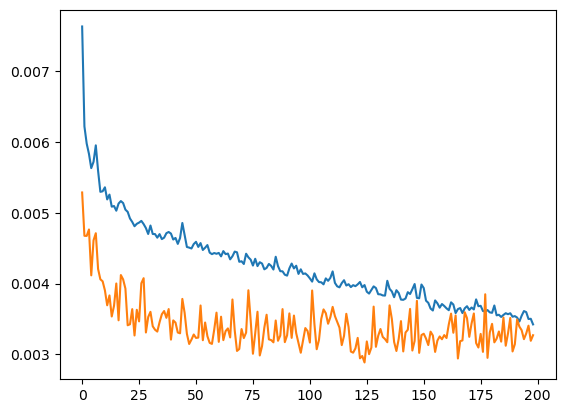

In [55]:
plt.plot(loss[1:])
plt.plot(val_loss[1:])
# plt.plot(grads[1:])

In [56]:
torch.save(model.state_dict(), r'checkpoints/EU1')

In [59]:
model.eval()
trset1, trset2, valset, testset = get_datasets(BPTT_WINDOW, PRED_WINDOW)

In [60]:
pred, targ = [], []
with torch.no_grad():
    for X, y in DataLoader(trset2, BATCH_SIZE, sampler=SequentialSampler(trset2)):
        pred.append((model(X.cuda()).detach()*mask).cpu())
        targ.append(y.cpu()*mask.cpu())
pred, targ = np.clip(torch.concat(pred, 0).numpy(),0,1), torch.concat(targ, 0).numpy()
diff = (pred-targ)*(targ>0)
max(np.abs(diff.min()), diff.max())

0.93607974

In [61]:
fig = plt.figure(figsize=(12, 8))
ax = fig.subplots(3, BPTT_WINDOW)
predim, targim, difim = [], [], []
for im, row, imgs, norm in zip((predim, targim, difim), ax, (pred, targ, diff), (Normalize(0,1), Normalize(0,1), Normalize(-1, 1))):
    for i in range(BPTT_WINDOW):
        im.append(row[i].imshow(imgs[0, i], norm=norm))
        row[i].axis('off')
plt.close()

def init():
    for i, sim in enumerate(predim):
        sim.set_data(pred[0, i])
    for i, sim in enumerate(targim):
        sim.set_data(targ[0, i])
    for i, sim in enumerate(difim):
        sim.set_data(diff[0, i])

def animate(i):
    for ims, imgs in zip((predim, targim, difim), (pred, targ, diff)):
        for j, im in enumerate(ims):
            im.set_data(imgs[i, j])
    return (predim, targim)

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=pred.shape[0], interval=500)
HTML(anim.to_html5_video())

In [46]:
anim.save('checkpoint/EU1-tr2.mp4', writer = animation.FFMpegWriter())